In [1]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import io 
import PIL
import freud
import matplotlib.pyplot as plt

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    vertices = [
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)

    geometry = fresnel.geometry.Polygon(
        scene, vertices = vertices, N=len(snapshot.particles.position)
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([100 / 255, 216 / 255, 230 / 255]), roughness=0.2
    )
    positions = numpy.array(snapshot.particles.position)[:, :2]
    geometry.position[:] = positions

    orientations = numpy.array(snapshot.particles.orientation)
    angles = 2 * numpy.arctan2(orientations[:, 3], orientations[:, 0])
    geometry.angle[:] = angles
    
    geometry.outline_width = 0.01

    fresnel.geometry.Box(scene, [L, L, 0.1, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, 10), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [64]:
m = 5
N_particles = m**2
spacing = 2
K = math.ceil(N_particles ** (1 / 2))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = [(px, py, 0) for px, py in itertools.product(x, x)][:N_particles]
orientation = [(1, 0, 0, 0)] * N_particles

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.orientation = orientation[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, 0, 0, 0, 0]
frame.particles.types = ['Squares']


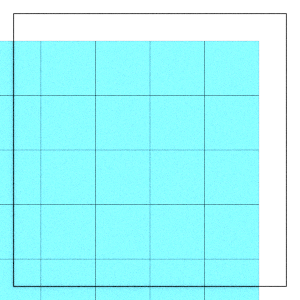

In [65]:
render(frame)

In [67]:
fn = os.path.join(os.getcwd(), 'lattice_sq_v2.gsd')
![ -e "$fn" ] && rm "$fn"

with gsd.hoomd.open(name='lattice_sq_v2.gsd', mode='x') as f:
    f.append(frame)

In [99]:
cpu = hoomd.device.CPU()

In [100]:
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='lattice_sq_v2.gsd')

In [101]:
fn = os.path.join(os.getcwd(), 'trajectory_expansion_v2.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_expansion_v2.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [102]:
def expand(simulation, betaP, weight, target, s, run_steps, log_interval=100):
    mc = hoomd.hpmc.integrate.ConvexPolygon()
    mc.shape['Squares'] = dict(
        vertices=[
            (-1, -1),
            (1, -1),
            (1, 1),
            (-1, 1)
        ]
    )
    simulation.operations.integrator = mc

    # Calculate the final volume based on target volume fraction
    volume_particle = s ** 2
    target_rho = target / volume_particle

    boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(10),
        betaP=betaP
    )
    boxmc.volume = dict(mode='standard', weight=weight, delta=-5)  
    simulation.operations.updaters.append(boxmc)

    volume_fractions = []
    pressures = []
    
    for step in range(0, run_steps, log_interval):
        simulation.run(log_interval)
        
        current_vf = (simulation.state.N_particles * volume_particle) / simulation.state.box.volume
        current_pressure = betaP / current_vf
        
        volume_fractions.append(current_vf)
        pressures.append(current_pressure)
        
        print(f"Pressure {current_pressure}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")

        if current_vf <= target:
            break

    return volume_fractions, pressures


In [103]:
vf, pressure = expand(simulation=simulation, betaP=0.0001, weight=0.0001, target=0.01, s=2, run_steps=10_00000)

Pressure 0.000116944356583943: Overlaps = 0, Volume Fraction = 0.8551075308043592
Pressure 0.0001264856179251189: Overlaps = 0, Volume Fraction = 0.7906037195406777
Pressure 0.00013245333263316164: Overlaps = 0, Volume Fraction = 0.754982891045533
Pressure 0.00014816100682774134: Overlaps = 0, Volume Fraction = 0.6749414177258157
Pressure 0.00015558178250437416: Overlaps = 0, Volume Fraction = 0.6427487742479652
Pressure 0.00017171634030985978: Overlaps = 0, Volume Fraction = 0.5823557607828782
Pressure 0.00018437706300006502: Overlaps = 0, Volume Fraction = 0.5423668127307394
Pressure 0.00018903834556010735: Overlaps = 0, Volume Fraction = 0.5289932034884617
Pressure 0.0001900708058624527: Overlaps = 0, Volume Fraction = 0.5261197244166279
Pressure 0.00019406697486885855: Overlaps = 0, Volume Fraction = 0.5152860246704797
Pressure 0.00020138612268977662: Overlaps = 0, Volume Fraction = 0.4965585446721375
Pressure 0.00021548032564485984: Overlaps = 0, Volume Fraction = 0.46407949171569

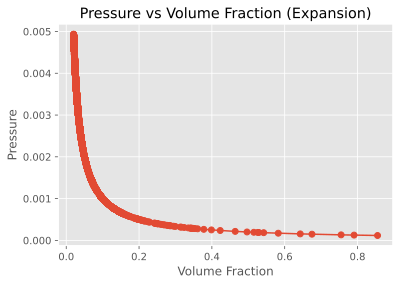

In [104]:
plt.figure(figsize=(6, 4))
plt.plot(vf, pressure, marker='o')
plt.xlabel('Volume Fraction')
plt.ylabel('Pressure')
plt.title('Pressure vs Volume Fraction (Expansion)')
plt.show()

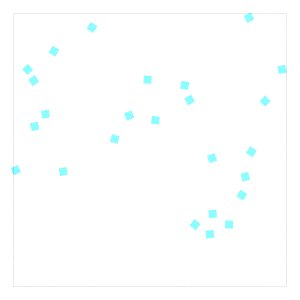

In [105]:
render(simulation.state.get_snapshot())

In [106]:
gsd_writer.flush()

In [107]:
del(simulation)

In [108]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_expansion_v2.gsd')

In [109]:
fn = os.path.join(os.getcwd(), 'trajectory_compress_v2.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_compress_v2.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [110]:
def compress(simulation, betaP, weight, run_steps, log_interval=100):
    mc = hoomd.hpmc.integrate.ConvexPolygon()
    mc.shape['Squares'] = dict(
        vertices=[
            (-1, -1),
            (1, -1),
            (1, 1),
            (-1, 1)
        ]
    )
    simulation.operations.integrator = mc

    boxmc = hoomd.hpmc.update.BoxMC(
        trigger=hoomd.trigger.Periodic(10),
        betaP=betaP
    )
    boxmc.volume = dict(mode='standard', weight=weight, delta=1)
    simulation.operations.updaters.append(boxmc)

    volume_fractions = []
    pressures = []
    
    for step in range(0, run_steps, log_interval):
        simulation.run(log_interval)
        
        # Calculate volume fraction and pressure
        current_vf = (simulation.state.N_particles * 2**2) / simulation.state.box.volume
        current_pressure = betaP / current_vf
        
        volume_fractions.append(current_vf)
        pressures.append(current_pressure)

        print(f"Pressure {current_pressure}: Overlaps = {mc.overlaps}, Volume Fraction = {current_vf}")
    
    return volume_fractions, pressures


In [ ]:
vf, pressure = compress(simulation=simulation, betaP=3, weight=1, run_steps=1000000)

Pressure 142.15213029891225: Overlaps = 0, Volume Fraction = 0.02110415083960902
Pressure 142.10883275655007: Overlaps = 0, Volume Fraction = 0.021110580826030494
Pressure 142.03962076393503: Overlaps = 0, Volume Fraction = 0.02112086743026368
Pressure 142.0184620935272: Overlaps = 0, Volume Fraction = 0.02112401413010887
Pressure 142.0494409902662: Overlaps = 0, Volume Fraction = 0.02111940729288454
Pressure 141.9535763520504: Overlaps = 0, Volume Fraction = 0.021133669732701085
Pressure 141.9532298771763: Overlaps = 0, Volume Fraction = 0.02113372131508189
Pressure 141.90249782852132: Overlaps = 0, Volume Fraction = 0.021141276904267592
Pressure 141.90802218937515: Overlaps = 0, Volume Fraction = 0.02114045389200424
Pressure 141.81968977777993: Overlaps = 0, Volume Fraction = 0.021153621226366798
Pressure 141.714589863197: Overlaps = 0, Volume Fraction = 0.0211693094048822
Pressure 141.63336410615554: Overlaps = 0, Volume Fraction = 0.021181449857757186
Pressure 141.62102916991358: O

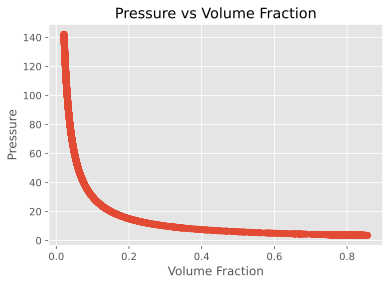

In [112]:
# Plot Pressure vs Volume Fraction
plt.figure(figsize=(6, 4))
plt.plot(vf, pressure, marker='o')
plt.xlabel('Volume Fraction')
plt.ylabel('Pressure')
plt.title('Pressure vs Volume Fraction')
plt.show()

In [113]:
gsd_writer.flush()

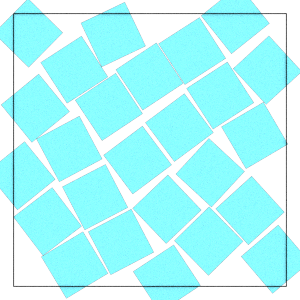

In [114]:
render(simulation.state.get_snapshot())